In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls ./

drive  sample_data


In [3]:
!mkdir data
!cp "/content/drive/My Drive/Colab Notebooks/split.zip" data/
!unzip ./data/split.zip -d ./data/
!rm ./data/split.zip

Archive:  ./data/split.zip
   creating: ./data/split/
   creating: ./data/split/train/
   creating: ./data/split/train/indoor/
  inflating: ./data/split/train/indoor/00000.jpg  
  inflating: ./data/split/train/indoor/00002.jpg  
  inflating: ./data/split/train/indoor/00003.jpg  
  inflating: ./data/split/train/indoor/00004.jpg  
  inflating: ./data/split/train/indoor/00005.jpg  
  inflating: ./data/split/train/indoor/00006.jpg  
  inflating: ./data/split/train/indoor/00007.jpg  
  inflating: ./data/split/train/indoor/00009.jpg  
  inflating: ./data/split/train/indoor/00010.jpg  
  inflating: ./data/split/train/indoor/00011.jpg  
  inflating: ./data/split/train/indoor/00012.jpg  
  inflating: ./data/split/train/indoor/00015.jpg  
  inflating: ./data/split/train/indoor/00016.jpg  
  inflating: ./data/split/train/indoor/00017.jpg  
  inflating: ./data/split/train/indoor/00018.jpg  
  inflating: ./data/split/train/indoor/00019.jpg  
  inflating: ./data/split/train/indoor/00022.jpg  
  infl

In [4]:
!ls ./data/split

train  valid


In [4]:
!rm -r ./data/all_data/
!mkdir ./data/all_data/
!cp -r ./data/split/train/* ./data/all_data/
!cp -r ./data/split/valid/* ./data/all_data/
!ls ./data/all_data/

indoor	outdoor


In [0]:
import cv2
import os

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from collections import deque
from shutil import copyfile
import numpy as np
import ntpath
import math
from sklearn import metrics
import pandas as pd

In [0]:
plt.style.use("ggplot")

In [0]:
batch_size = 128
generator_dimensions = (224, 224)
train_source_folder = "./data/split/train"
test_source_folder = "./data/split/valid"
all_data_source_folder = "./data/all_data/"

In [5]:
base_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet', pooling = 'max')
base_model.summary()

W0616 08:45:05.030727 139732843902848 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# add_model = Flatten()(base_model.output)
add_model = base_model.output
add_model = Dense(1024)(add_model)
add_model = BatchNormalization()(add_model)
add_model = Activation("relu")(add_model)
add_model = Dense(512)(add_model)
add_model = BatchNormalization()(add_model)
add_model = Activation("relu")(add_model)
output_layer = Dense(1, activation="sigmoid")(add_model)

model = Model(inputs=[base_model.input], outputs=[output_layer])


for l in base_model.layers[0:15]:
    model.get_layer(l.name).trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

W0616 08:45:09.097915 139732843902848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_source_folder,
        target_size=generator_dimensions,
        batch_size=batch_size,
        class_mode='binary') 

test_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        test_source_folder,
        target_size=generator_dimensions,
        batch_size=batch_size,
        class_mode='binary') 

Found 3448 images belonging to 2 classes.
Found 862 images belonging to 2 classes.


In [0]:
train_steps_per_epoch = train_generator.samples // batch_size
test_steps_per_epoch = test_generator.samples // batch_size

print(f"Train steps: {train_steps_per_epoch}. Test steps: {test_steps_per_epoch}")

Train steps: 26. Test steps: 6


In [0]:
checkpoints = [
    ModelCheckpoint("./weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min'), 
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, mode='min')
]

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100, 
    verbose=1, 
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch,
    callbacks=checkpoints
)

Epoch 1/100
26/26 [==============================] - 49s 2s/step - loss: 0.2278 - val_loss: 9.4919
Epoch 2/100
26/26 [==============================] - 40s 2s/step - loss: 0.1031 - val_loss: 3.9459
Epoch 3/100
26/26 [==============================] - 39s 1s/step - loss: 0.0743 - val_loss: 0.1189
Epoch 4/100
26/26 [==============================] - 38s 1s/step - loss: 0.0601 - val_loss: 0.1117
Epoch 5/100
26/26 [==============================] - 38s 1s/step - loss: 0.0356 - val_loss: 0.5518
Epoch 6/100
26/26 [==============================] - 37s 1s/step - loss: 0.0443 - val_loss: 0.1172
Epoch 7/100
26/26 [==============================] - 38s 1s/step - loss: 0.0383 - val_loss: 2.3352
Epoch 8/100
26/26 [==============================] - 37s 1s/step - loss: 0.0272 - val_loss: 0.6513
Epoch 9/100
26/26 [==============================] - 37s 1s/step - loss: 0.0194 - val_loss: 0.0836
Epoch 10/100
26/26 [==============================] - 37s 1s/step - loss: 0.0233 - val_loss: 0.1095
Epoch 11/

In [0]:
model.load_weights("./weights.h5")
model.save("./model_trained.h5")

In [0]:
!cp ./weights.h5 "/content/drive/My Drive/Colab Notebooks/weights.h2"
!cp ./model_trained.h5 "/content/drive/My Drive/Colab Notebooks/model_trained.h2"

In [0]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/weights.h2")

In [0]:
def convert_folder_into_data(input_folder):
  ret_data = None
  for root, dirs, files in os.walk(input_folder):
    inputs = np.array([cv2.imread(os.path.join(root, file)) for file in files])
    if len(inputs) == 0:
      continue
    if ret_data is None:
      ret_data = inputs
    else:
      ret_data = np.vstack((ret_data, inputs))
  
  print(f"Found {len(inputs)} images. Shape: {inputs.shape}")
  return ret_data / 255.
  

def predict_probas(input_folder, input_model):
  inputs = convert_folder_into_data(input_folder)
#   inputs = inputs / 255.
  predictions = input_model.predict(inputs)
  return predictions

def show_confidence_predictions(input_folder, input_model, type_name):
  predictions = predict_probas(input_folder, input_model)
  plt.hist(np.around(predictions, decimals=2))
  plt.xlabel("Confidence")
  plt.ylabel("Count")
  plt.legend(["Indoor", "Outdoor"], loc='upper right', ncol=1)
  plt.title(f"{type_name} histogram")
  plt.show()
  return predictions


Found 1547 images. Shape: (1547, 224, 224, 3)


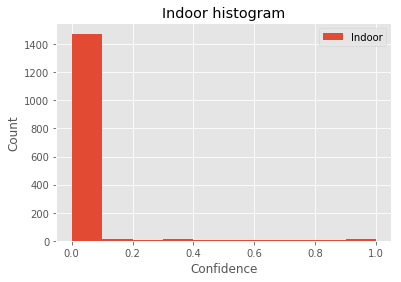

Found 1901 images. Shape: (1901, 224, 224, 3)


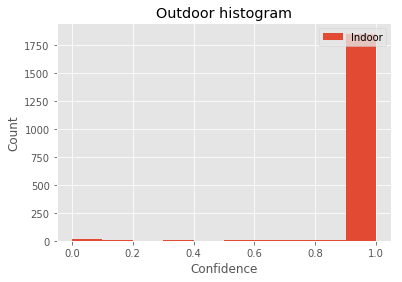

In [59]:
indoor_train_preds = show_confidence_predictions(f"{train_source_folder}/indoor", model, "Indoor")
outdoor_train_preds = show_confidence_predictions(f"{train_source_folder}/outdoor", model, "Outdoor")

Found 387 images. Shape: (387, 224, 224, 3)


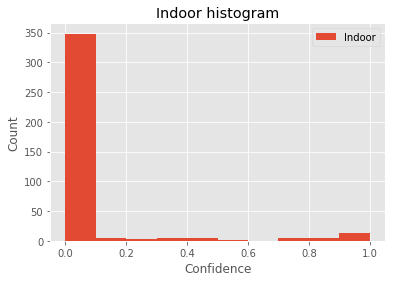

Found 475 images. Shape: (475, 224, 224, 3)


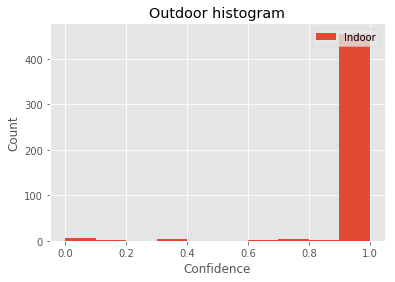

In [15]:
indoor_test_preds = show_confidence_predictions(f"{test_source_folder}/indoor", model, "Indoor")
outdoor_test_preds = show_confidence_predictions(f"{test_source_folder}/outdoor", model, "Outdoor")

In [0]:
def create_roc_curve(input_folder, input_model):
  indoor_folder = os.path.join(input_folder, "indoor")
  indoor_predictions = predict_probas(indoor_folder, input_model)
  indoor_Y_true = np.zeros(len(indoor_predictions))

  outdoor_folder = os.path.join(input_folder, "outdoor")
  outdoor_predictions = predict_probas(outdoor_folder, input_model)
  outdoor_Y_true = np.ones(len(outdoor_predictions))

  Y_true = np.hstack((indoor_Y_true, outdoor_Y_true))
  Y_pred = np.vstack((indoor_predictions, outdoor_predictions))
  fpr, tpr, thresholds = metrics.roc_curve(Y_true, Y_pred)
  return fpr, tpr, thresholds

def find_best_threshold(input_folder, input_model):
  fpr, tpr, thresholds = create_roc_curve(input_folder, input_model)
  roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr, "Threshold": thresholds, "Cutoff-index": abs(tpr - (1-fpr))})
  return roc_df.sort_values("Cutoff-index").iloc[0]["Threshold"]

In [56]:
train_threshold = find_best_threshold(train_source_folder, model)
test_threshold = find_best_threshold(test_source_folder, model)
all_data_threshold = find_best_threshold(all_data_source_folder, model)

print(f"Train threshold: {train_threshold}, Test threshold: {test_threshold}, All threshold: {all_data_threshold}")

Found 1547 images. Shape: (1547, 224, 224, 3)
Found 1901 images. Shape: (1901, 224, 224, 3)
Found 387 images. Shape: (387, 224, 224, 3)
Found 475 images. Shape: (475, 224, 224, 3)
Found 1934 images. Shape: (1934, 224, 224, 3)
Found 2376 images. Shape: (2376, 224, 224, 3)
Train threshold: 0.6543647050857544, Test threshold: 0.8304610848426819, All threshold: 0.7375586628913879


In [0]:
def compute_metrics(input_folder, input_model, threshold = 0.83):
  indoor_folder = os.path.join(input_folder, "indoor")
  indoor_picture = convert_folder_into_data(indoor_folder)
  indoor_predictions = predict_images(indoor_picture, input_model, threshold)
  indoor_Y_true = np.zeros(len(indoor_predictions))

  outdoor_folder = os.path.join(input_folder, "outdoor")
  outdoor_picture = convert_folder_into_data(outdoor_folder)
  outdoor_predictions = predict_images(outdoor_picture, input_model, threshold)
  outdoor_Y_true = np.ones(len(outdoor_predictions))

  Y_true = np.hstack((indoor_Y_true, outdoor_Y_true))
  Y_pred = np.vstack((indoor_predictions, outdoor_predictions))
  
  auc = metrics.roc_auc_score(Y_true, Y_pred)
  acc = metrics.accuracy_score(Y_true, Y_pred)
  f1 = metrics.f1_score(Y_true, Y_pred)
  
  return auc, acc, f1
  
def predict_images(images, input_model, threshold):
  return (input_model.predict(images) >  threshold).astype(np.uint8)


def print_scores(input_folder, input_model, name):
  threshold = 0.83
  auc, acc, f1 = compute_metrics(input_folder, input_model, threshold = threshold)  
  print(f"{name} metrics (threshold: {threshold}) - [AUC: {auc}, Accuracy: {acc}, F1: {f1}]")

In [11]:
print_scores(train_source_folder, model, "Train")
print_scores(test_source_folder, model, "Test")
print_scores(all_data_source_folder, model, "All data")

Found 1547 images. Shape: (1547, 224, 224, 3)
Found 1901 images. Shape: (1901, 224, 224, 3)
Train metrics (threshold: 0.83) - [AUC: 0.9848941478424413, Accuracy: 0.984338747099768, F1: 0.9857067231339334]
Found 387 images. Shape: (387, 224, 224, 3)
Found 475 images. Shape: (475, 224, 224, 3)
Test metrics (threshold: 0.83) - [AUC: 0.9569835441316469, Accuracy: 0.95707656612529, F1: 0.9609292502639916]
Found 1934 images. Shape: (1934, 224, 224, 3)
Found 2376 images. Shape: (2376, 224, 224, 3)
All data metrics (threshold: 0.83) - [AUC: 0.9793111657770396, Accuracy: 0.9788863109048724, F1: 0.9807407407407407]
